In [1]:
import argparse
import pickle
import os
import time
import matplotlib.pyplot as plt
import numpy as np

import data
import equations

from gp_utils import *
from interpolate import get_ode_data
from collections import Counter
sys.path.append("/Users/gcohn/Documents/D-CODE-ICLR-2022/")

In [2]:
def gp_to_pysym(f_star, ode):
    VarDict = ode.get_var_dict()
    f_star_list, var_list, coef_list = parse_program_to_list(f_star.program)
    f_star_infix = generator.Generator.prefix_to_infix(
        f_star_list, variables=var_list, coefficients=coef_list
    )
    f_star_infix2 = f_star_infix.replace("{", "").replace("}", "")
    if f_star_infix2 == f_star_infix:
        f_star_sympy = generator.Generator.infix_to_sympy(
            f_star_infix, VarDict, "simplify"
        )
        return f_star_sympy

    f_star_sympy = generator.Generator.infix_to_sympy(
        f_star_infix2, VarDict, "simplify"
    )
    return f_star_sympy


def std_RMSE(err_sq):
    rmse_list = []
    for i in range(500):
        new_err = err_sq[np.random.randint(0, len(err_sq), err_sq.shape)]
        rmse_itr = np.sqrt(np.mean(new_err))
        rmse_list.append(rmse_itr)
    return np.std(np.array(rmse_list))

In [3]:
dim_x, x_id, n_sample = 8, 1, 800
seed_s, seed_e = 0, 2
ode_name = "real"
dg = data.DataGeneratorLHM(dim_x, n_sample)
# mask = dg.mask
yt = dg.generate_data()
ode = equations.LHMODEPlaceHolder()
ode_data, X_ph, y_ph, t_new = get_ode_data(yt, x_id, dg, ode)


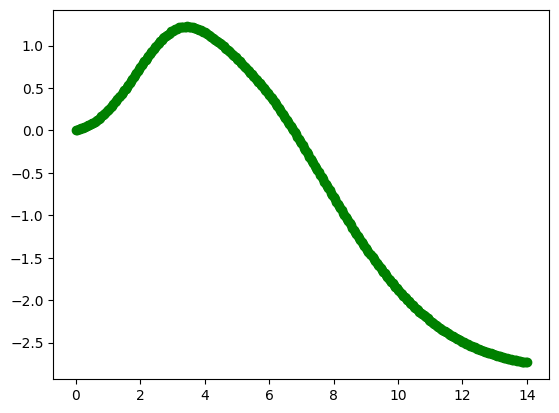

In [4]:
plt.plot(ode_data["x_hat"][:, 0, -1], ode_data["x_hat"][:, 0, 5], 'go')

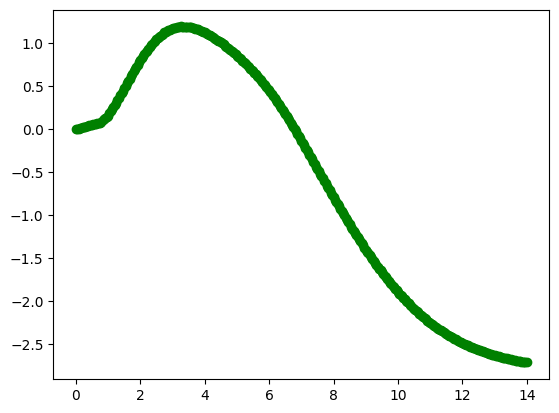

In [6]:
plt.plot(yt[:, 0, -1], yt[:, 0, 5], 'go')

## D-CODE

In [7]:
np.random.seed(10)

In [8]:
path_base = "results_vi/{}/sample-{}/dim-{}/".format('lhm', '800', 8)

In [16]:
complete_res_list = []
path = path_base + "grad_x_{}_seed_{}_train_medium.pkl".format(5, 2)
with open(path, "rb") as f:
    res = pickle.load(f)
    complete_res_list.append([res])
path = path_base + "grad_x_{}_seed_{}_train_medium.pkl".format(6, 2)
with open(path, "rb") as f:
    res = pickle.load(f)
    complete_res_list.append([res])

In [17]:
#compare the true derivate trajectory with the trajectory above

HillCure: float = 2
HillPatho: float = 2
ec50_patho: float = 1
emax_patho: float = 1
k_dexa: float = 1
k_discure_immunereact: float = 1
k_discure_immunity: float = 1
k_disprog: float = 1
k_immune_disease: float = 1
k_immune_feedback: float = 1
k_immune_off: float = 1
k_immunity: float = 1
kel: float = 1

In [18]:
ind = 0
from functools import partial

def ones_func(x):
    return 1.0

def expert_mask(func, x):
    x = x.copy()
    x[0,5:7] = 0
    return func(x)

def x2(x):
    return x[0,1]

def x0(x):
    Disease = x[0,0]
    ImmuneReact = x[0,1]
    # Dose2 = x[0,3]
    Immunity = x[0,2]
    dxdt1 = (
                Disease * k_disprog
                - Disease * Immunity ** HillCure * k_discure_immunity
                - Disease * ImmuneReact * k_discure_immunereact
            )
    return dxdt1

def x1(x):
    Disease = x[0,0]
    ImmuneReact = x[0,1]
    Dose2 = x[0,3]
    dxdt2 = (
                Disease * k_immune_disease
                - ImmuneReact * k_immune_off
                + Disease * ImmuneReact * k_immune_feedback
                + (ImmuneReact ** HillPatho * emax_patho)
                / (ec50_patho ** HillPatho + ImmuneReact ** HillPatho)
                - Dose2 * ImmuneReact * k_dexa
            )
    return dxdt2

def x3(x):
    Dose = x[0,4]
    Dose2 = x[0,3]
    return kel * Dose - kel * Dose2
    
def dose_at_time(x):
    return -1*x[0,4]

f_list = []
for i in range(8):
    if i < 4:
        if i == 1:
            f_list.append(x1)
        elif i == 2:
            f_list.append(x2)
        elif i == 3:
            f_list.append(x3)
        else:
            f_list.append(x0)
    elif i == 4:
        f_list.append(dose_at_time)
    elif i <= 6:
        f_list.append(complete_res_list[i-5][0]["model"].execute)
    elif i == 7:
        f_list.append(ones_func)



In [19]:
print(dg.xt[0,2,4])
print(dg.xt[0,2,:])

8.895081520080566
[1.20096619e-03 2.24029609e-05 1.94387285e-05 2.40899662e-05
 8.89508152e+00 3.51909330e-05 2.31813065e-05 0.00000000e+00]


In [20]:
ode_hat = equations.InferredODE(dim_x, f_hat_list=f_list, T=dg.T)
base = dg.xt[0,2,:]
dg_hat = data.DataGenerator(
    ode_hat,
    dg.T,
    freq=dg.freq,
    n_sample=10,
    noise_sigma=0.0,
    
    init_low = [b-.01 for b in base],
    init_high = [b+.01 for b in base]#[b+.01 for b in base],
)

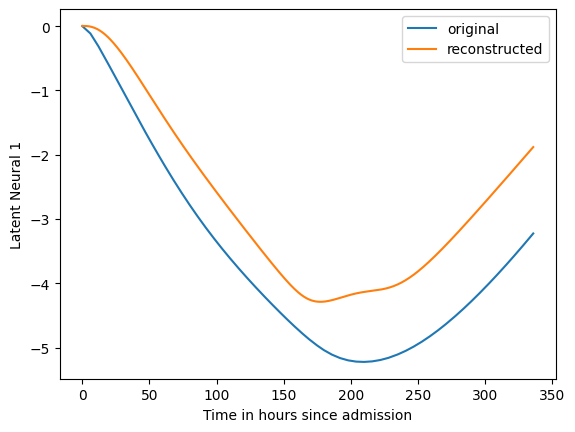

In [21]:
plt.plot(yt[:, 2, 6], label="original")
plt.plot(dg_hat.xt[:, 2, 6], label="reconstructed")
plt.xlabel("Time in hours since admission")
plt.ylabel("Latent Neural 1")
leg = plt.legend(loc='upper right')